# CAPSTONE PROJECT 
 - Student- Sabina Bains
 - Presentation Date- 10/01/2022
 - Instructor- Abhineet Kulkarni

# BUSINESS UNDERSTANDING ------------------------------------------------------------------------------------------

A picture is said to be worth a thousand words, but does that saying apply to album art? Before streaming services such as Spotify became the preferred format for music consumption,
listeners would peruse the aisles of music stores, scanning the album artwork of CD's and Vinyl Records. During this time, album art likely affected what users chose to purchase. Our goal is to predict whether album art still plays a role in the success of the album's music, and if so, which album covers are predicted to be most sucessful?


active vs passive listening. 
album art tells a story and gives context

To do this we will experiment with Convolutional Neural Networks, a class of Neural Networks that deals with handling Image data.



# DATA UNDERSTANDING ------------------------------------------------------------------------------------------------

In [ ]:
!pip3 install spotipy --upgrade
!pip3 install pillow

#### Importing Packages

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from matplotlib import image as mpimg
 
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
import re
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os

# changing colors of output
COLOR = 'white'
mpl.rcParams['text.color'] = 'grey'
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import os
import pandas as pd

# load and show an image with Pillow
from PIL import Image


from matplotlib import pyplot

import requests

from IPython.display import Image as img_display

import collections

#### Using credentials to pull album art and popularity score (target variable) from Spotify's API (SpotiPy)

In [2]:
# User will have to create their own spotipy account and put their own CID and SECRET keys into the following variables
creds  = pd.read_csv('data/spotipy_credentials.csv', header = None)

cid    = creds[1][0]
secret = creds[1][1]

In [3]:
# Accessing API
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [4]:
# Creating list of playlists with independent artists to pull album art data from
fresh_finds_playlists = [
'https://open.spotify.com/playlist/37i9dQZF1DWT0upuUFtT7o',
'https://open.spotify.com/playlist/37i9dQZF1DWUFAJPVM3HTX',
'https://open.spotify.com/playlist/37i9dQZF1DX3u9TSHqpdJC',
'https://open.spotify.com/playlist/37i9dQZF1DWW4igXXl2Qkp',
'https://open.spotify.com/playlist/37i9dQZF1DX78toxP7mOaJ',
'https://open.spotify.com/playlist/37i9dQZF1DXdS3lvGe1GrT',
'https://open.spotify.com/playlist/37i9dQZF1DWYUfsq4hxHWP',
'https://open.spotify.com/playlist/37i9dQZF1DX6bBjHfdRnza',
'https://open.spotify.com/playlist/37i9dQZF1DX8C585qnMYHP',
'https://open.spotify.com/playlist/37i9dQZF1DXcWL5K0oNHcG',
'https://open.spotify.com/playlist/37i9dQZF1DWWjGdmeTyeJ6'
]

In [5]:
# looping through playlist lists to pull all tracks from each list
playlist_uris = []

for playlist in fresh_finds_playlists:
    playlist_uris.append(playlist.split("/")[-1].split("?")[0])

In [6]:
playlist_uri_to_name_dict = {}

for playlist_uri in playlist_uris:
    playlist_name = sp.user_playlist(user=None, playlist_id=playlist_uri, fields="name")['name']
    
    if playlist_name != "Fresh Finds":
        playlist_name = playlist_name.split(' ')[-1]
    else:
        playlist_name = 'All Genres'
        
    playlist_uri_to_name_dict[playlist_uri] = playlist_name

In [7]:
# Creating dict to append to
data={}
data['track_name'] = []
data['popularity'] = []
data['album_url'] = []
data['playlist_uri'] = []


# looping through each playlist
for playlist in playlist_uris:
    
    # looping through each track in playlist to append name, popularity rating (our target variable), and album url to pull artwork.
    for track in sp.playlist_tracks(playlist)["items"]:
        # track name
        data['track_name'].append(track["track"]["name"])
        # popularity of the track
        data['popularity'].append(track["track"]["popularity"])
        # Cover Art URL
        data['album_url'].append(track["track"]['album']['images'][0]['url'])
        # playlist URI for matching later
        data['playlist_uri'].append(playlist)

In [8]:
# creating dataframe from above dictionary
df = pd.DataFrame(data)

In [9]:
# adding in playlist genre
df['playlist_name'] = df.playlist_uri.replace(playlist_uri_to_name_dict)

In [10]:
len(df)

895

In [11]:
# dropping any potential duplicates 
df = df.drop_duplicates().reset_index(drop = True)

In [12]:
# cleaning track names of characters for cleaner import and export
df['track_name_cleaned'] = df.track_name.str.replace("(?i)[^0-9a-z!?.;,@' -]",'')
df['track_name_cleaned'] = df.track_name_cleaned.str.replace('.','')
df['track_name_cleaned'] = df.track_name_cleaned.str.replace('*','')
df['track_name_cleaned'] = df.track_name_cleaned.str.strip()

In [13]:
df['key'] = df['track_name_cleaned']+"_"+df['playlist_name']

In [14]:
# sorting data by trackname to match album art with popularity score
df = df.sort_values(by='key').reset_index(drop=True)

In [15]:
# # Going through each URL, downloading the image, and saving it to album_art folder
# error_list = []
# for key, url in zip(df['key'], df['album_url']):
    
#     try:
#         img_data = requests.get(url).content
#         with open(f'data/album_art/{key}.jpg', 'wb') as handler:
#             handler.write(img_data)
#     except:
#         error_list.append(key)

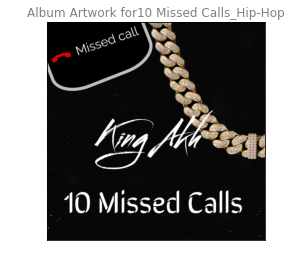

In [17]:
# Displaying example of photo
album_art_example = mpimg.imread("data/album_art/"+df.key[0]+".jpg")
plt.imshow(album_art_example)


plt.title("Album Artwork for"+df.key[0])
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")


plt.show()

In [19]:
# importing saved album art files as values in dictionary, with key being the track name. This is so we can later tie the target variable to the features (album art)

# initializing dict
image_dict = {}

# looping through each album art saved
for file in os.listdir("data/album_art/"):
    
    filename = file.split('.jpg')[0]
    
    # assigning track name as key, and value as matrix form of album art (Height, Width, Depth)
    try:
        image_dict[filename] = (mpimg.imread('data/album_art/'+file))
        
        # Not including image if it is not in uniform shape
        if image_dict[filename].shape == (640,640):
                image_dict[filename] = np.stack((image_dict[filename],)*3, axis=-1)
                
                newshape = image_dict[filename].shape
                print(file+' was resized to '+str(newshape)) 
            
        if image_dict[filename].shape != (640,640,3):
            del image_dict[filename]
            
    # created error list to observe files that were not read in properly        
    except:
        print(file+' did not import')

Say Datt_Hip-Hop.jpg was resized to (640, 640, 3)
.DS_Store did not import
Consolation Prize_Rock.jpg was resized to (640, 640, 3)
Family Man_Rock.jpg was resized to (640, 640, 3)
Say Datt_All Genres.jpg was resized to (640, 640, 3)
Goner feat Kellin Quinn_Rock.jpg was resized to (640, 640, 3)
At Least_Folk.jpg was resized to (640, 640, 3)
Portals_R&B.jpg was resized to (640, 640, 3)
Face the Music_Experimental.jpg was resized to (640, 640, 3)
Grimiest Ever_Dance.jpg was resized to (640, 640, 3)
WORK 4 A SMILE DEMO_R&B.jpg was resized to (640, 640, 3)
The Wolves_Country.jpg was resized to (640, 640, 3)
Black Visa_Hip-Hop.jpg was resized to (640, 640, 3)


In [20]:
# filtering down dataframe so that only the files that were read in properly are included. 
filtered_df = df.loc[df.key.isin(image_dict.keys())]

In [21]:
filtered_df.duplicated().sum()

0

In [22]:
del_list = []

for key in image_dict.keys():
    if key in df.key.to_list():
        pass
    else:
        print("Could not find associated value for "+key+", delete from the album art dictionary")
        del_list.append(key)
        
for key in del_list:
    del image_dict[key]

Could not find associated value for .SYSTVMRVSTVRT, delete from the album art dictionary
Could not find associated value for .SYSTVMRVSTVRT*, delete from the album art dictionary


In [23]:
# Sorting Dictionary to match DataFrame order
image_dict = collections.OrderedDict(sorted(image_dict.items()))

In [24]:
# Checking if order of names matches, so we can accuractly match features with target data. 
filtered_df.key.to_list() == list(image_dict.keys())

True

# DATA PREPARATION -----------------------------------------------------------------------------------------------------

In [25]:
X = np.array(list(image_dict.values()))

In [26]:
X.shape

(875, 640, 640, 3)

In [27]:
y = np.array(filtered_df.popularity).reshape(len(filtered_df.popularity), 1)

In [28]:
y.shape

(875, 1)

In [29]:
# Split the data into Train and Test, so we can later validate our model on "unseen" data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [30]:
X_train = X_train / 255
X_test  = X_test  / 255

# ----------------------------------------------------- MODELING ---------------------------------------------------------

In [ ]:
def evaluate_model(model, thr):
    plt.plot(history.history['mse'], label='mse')
    plt.plot(history.history['val_mse'], label = 'val_mse')
    plt.xlabel('Epoch')
    plt.ylabel('mse')
    plt.legend(loc='lower right')

    test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
    
    
    y_hat = model.predict(X_test);
    error = y_test - y_hat;
    
    numCorrect = sum(abs(error) < thr);
    numValidationImages = len(y_test);

    accuracy = numCorrect/numValidationImages
    accuracy
    
    squares = error**2;
    rmse = np.sqrt(np.mean(squares))
    
    plt.scatter(y_hat,y_test)
    plt.xlabel("Predicted Value")
    plt.ylabel("True Value")

    # plt.plot(np.linspace(10,55,10))

    plt.xlim([10, 55])
    plt.ylim([10, 55])
    

The first model I will be running is a Convolutional Neural Network with one pooling layer and a flattening layer. 

In [32]:
model_1 = Sequential()
model_1.add(layers.Conv2D(64, kernel_size=1, input_shape = X_train[0].shape))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(Flatten())
model_1.add(layers.Dense(1, activation='linear'))

In [33]:
model_1.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

In [34]:
history = model.fit(X_train, y_train, epochs=5, 
                    validation_data=(X_test, y_test))

Epoch 1/5
21/21 [==============================] - 335s 16s/step - loss: 76332.9219 - mse: 76332.9219 - val_loss: 26640.1445 - val_mse: 26640.1445
Epoch 2/5
21/21 [==============================] - 271s 13s/step - loss: 6020.3379 - mse: 6020.3379 - val_loss: 699.5198 - val_mse: 699.5198
Epoch 3/5
21/21 [==============================] - 263s 13s/step - loss: 1071.8613 - mse: 1071.8613 - val_loss: 281.8731 - val_mse: 281.8731
Epoch 4/5
21/21 [==============================] - 278s 13s/step - loss: 396.3245 - mse: 396.3245 - val_loss: 235.4261 - val_mse: 235.4261
Epoch 5/5
21/21 [==============================] - 289s 14s/step - loss: 243.2515 - mse: 243.2515 - val_loss: 150.7756 - val_mse: 150.7756


7/7 - 11s - loss: 150.7756 - mse: 150.7756


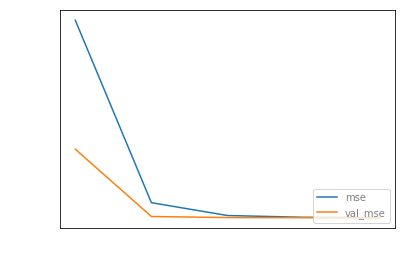

In [35]:
plt.plot(history.history['mse'], label='mse')
plt.plot(history.history['val_mse'], label = 'val_mse')
plt.xlabel('Epoch')
plt.ylabel('mse')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [36]:
y_hat = model.predict(X_test);

In [37]:
error = y_test - y_hat;

In [38]:
thr = 10;
numCorrect = sum(abs(error) < thr);
numValidationImages = len(y_test);

accuracy = numCorrect/numValidationImages

In [39]:
accuracy

array([0.60730594])

In [41]:
squares = error**2;
rmse = np.sqrt(np.mean(squares))

(10.0, 55.0)

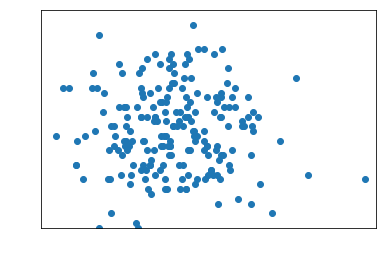

In [42]:
plt.scatter(y_hat,y_test)
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

# plt.plot(np.linspace(10,55,10))

plt.xlim([10, 55])
plt.ylim([10, 55])

### DATA PROCESSING PT. 2 - CHANGING PIXEL SIZE

In [46]:
for name in os.listdir('data/album_art'):
    try:
        img = Image.open('data/album_art/'+name)
        img = img.resize((60,60))
        img.save('data/album_art_resized/'+name)
    except:
        print(name+' did not import')

.DS_Store did not import


In [47]:
# importing saved album art files as values in dictionary, with key being the track name. This is so we can later tie the target variable to the features (album art)

# initializing dict
resized_image_dict = {}

# looping through each album art saved
for file in os.listdir("data/album_art_resized/"):
    
    filename = file.split('.jpg')[0]
    
    # assigning track name as key, and value as matrix form of album art (Height, Width, Depth)
    try:
        resized_image_dict[filename] = (mpimg.imread('data/album_art_resized/'+file))
        
        # Not including image if it is not in uniform shape
        if resized_image_dict[filename].shape == (60,60):
                resized_image_dict[filename] = np.stack((resized_image_dict[filename],)*3, axis=-1)
                
                newshape = resized_image_dict[filename].shape
                print(file+' was resized to '+str(newshape)) 
            
        if resized_image_dict[filename].shape != (60,60,3):
            del resized_image_dict[filename]
            
    # created error list to observe files that were not read in properly        
    except:
        print(file+' did not import')

Say Datt_Hip-Hop.jpg was resized to (60, 60, 3)
.DS_Store did not import
Consolation Prize_Rock.jpg was resized to (60, 60, 3)
Family Man_Rock.jpg was resized to (60, 60, 3)
Say Datt_All Genres.jpg was resized to (60, 60, 3)
Goner feat Kellin Quinn_Rock.jpg was resized to (60, 60, 3)
At Least_Folk.jpg was resized to (60, 60, 3)
Portals_R&B.jpg was resized to (60, 60, 3)
Face the Music_Experimental.jpg was resized to (60, 60, 3)
Grimiest Ever_Dance.jpg was resized to (60, 60, 3)
WORK 4 A SMILE DEMO_R&B.jpg was resized to (60, 60, 3)
The Wolves_Country.jpg was resized to (60, 60, 3)
Black Visa_Hip-Hop.jpg was resized to (60, 60, 3)


In [54]:
# filtering down dataframe so that only the files that were read in properly are included. 
resized_filtered_df = df.loc[df.key.isin(resized_image_dict.keys())]

In [56]:
len(resized_filtered_df)

895

In [57]:
resized_filtered_df.duplicated().sum()

0

In [59]:
del_list = []

for key in resized_image_dict.keys():
    if key in df.key.to_list():
        pass
    else:
        print("Could not find associated value for "+key+", delete from the album art dictionary")
        del_list.append(key)
        
for key in del_list:
    del resized_image_dict[key]

Could not find associated value for .SYSTVMRVSTVRT, delete from the album art dictionary
Could not find associated value for .SYSTVMRVSTVRT*, delete from the album art dictionary


In [60]:
# Sorting Dictionary to match DataFrame order
resized_image_dict = collections.OrderedDict(sorted(resized_image_dict.items()))

In [64]:
# Checking if order of names matches, so we can accuractly match features with target data. 
resized_filtered_df.key.to_list() == list(resized_image_dict.keys())

True

### DATA PREP PART 2 - REDUCED PIXEL SIZE

In [69]:
X = np.array(list(resized_image_dict.values()))
X.shape

(895, 60, 60, 3)

In [71]:
y = np.array(resized_filtered_df.popularity).reshape(len(resized_filtered_df.popularity), 1)
y.shape

(895, 1)

In [72]:
# Split the data into Train and Test, so we can later validate our model on "unseen" data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [73]:
X_train = X_train / 255
X_test  = X_test  / 255

## MODEL #2: REDUCED PIXELS

In [75]:
model = Sequential()
model.add(layers.Conv2D(64, kernel_size=1, input_shape = X_train[0].shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(layers.Dense(1, activation='linear'))

In [76]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

In [78]:
history = model.fit(X_train, y_train, epochs=5, 
                    validation_data=(X_test, y_test))

Epoch 1/5
21/21 [==============================] - 1s 52ms/step - loss: 113.9240 - mse: 113.9240 - val_loss: 130.6186 - val_mse: 130.6186
Epoch 2/5
21/21 [==============================] - 1s 46ms/step - loss: 111.7095 - mse: 111.7095 - val_loss: 149.2059 - val_mse: 149.2059
Epoch 3/5
21/21 [==============================] - 1s 32ms/step - loss: 111.8872 - mse: 111.8872 - val_loss: 127.7292 - val_mse: 127.7292
Epoch 4/5
21/21 [==============================] - 1s 31ms/step - loss: 104.4404 - mse: 104.4404 - val_loss: 124.6401 - val_mse: 124.6401
Epoch 5/5
21/21 [==============================] - 1s 31ms/step - loss: 101.3055 - mse: 101.3055 - val_loss: 124.7441 - val_mse: 124.7441


7/7 - 0s - loss: 124.7441 - mse: 124.7441


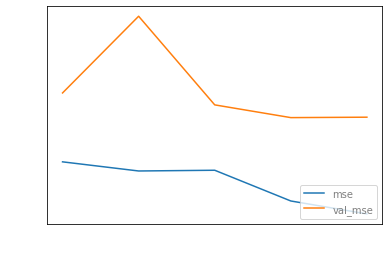

In [79]:
plt.plot(history.history['mse'], label='mse')
plt.plot(history.history['val_mse'], label = 'val_mse')
plt.xlabel('Epoch')
plt.ylabel('mse')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [80]:
y_hat = model.predict(X_test);
error = y_test - y_hat;

In [109]:
thr = 5;
numCorrect = sum(abs(error) < thr);
numValidationImages = len(y_test);

accuracy = numCorrect/numValidationImages

In [110]:
accuracy

array([0.40178571])

In [83]:
squares = error**2;
rmse = np.sqrt(np.mean(squares))

(10.0, 55.0)

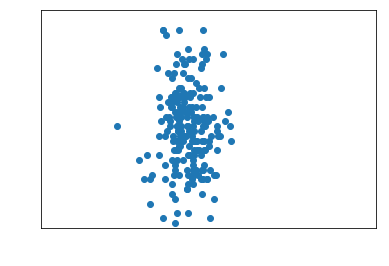

In [84]:
plt.scatter(y_hat,y_test)
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

# plt.plot(np.linspace(10,55,10))

plt.xlim([10, 55])
plt.ylim([10, 55])

`# Looks like it didn't converget. lets add more epochs and layers. 

### Model #3: added Conv2d layers and increase in epochs

In [89]:
model = Sequential()
model.add(layers.Conv2D(64, kernel_size=1, input_shape = X_train[0].shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

In [90]:
history = model.fit(X_train, y_train, epochs=15, 
                    validation_data=(X_test, y_test))

Epoch 1/15
21/21 [==============================] - 2s 104ms/step - loss: 433.3909 - mse: 433.3909 - val_loss: 236.4724 - val_mse: 236.4724
Epoch 2/15
21/21 [==============================] - 2s 102ms/step - loss: 202.0234 - mse: 202.0234 - val_loss: 176.7823 - val_mse: 176.7823
Epoch 3/15
21/21 [==============================] - 2s 103ms/step - loss: 158.9086 - mse: 158.9086 - val_loss: 154.0990 - val_mse: 154.0990
Epoch 4/15
21/21 [==============================] - 2s 108ms/step - loss: 127.0873 - mse: 127.0873 - val_loss: 126.6316 - val_mse: 126.6316
Epoch 5/15
21/21 [==============================] - 2s 105ms/step - loss: 127.1919 - mse: 127.1919 - val_loss: 168.1716 - val_mse: 168.1716
Epoch 6/15
21/21 [==============================] - 2s 100ms/step - loss: 118.4427 - mse: 118.4427 - val_loss: 128.3436 - val_mse: 128.3436
Epoch 7/15
21/21 [==============================] - 2s 104ms/step - loss: 121.7921 - mse: 121.7921 - val_loss: 123.0562 - val_mse: 123.0562
Epoch 8/15
21/21 [==

7/7 - 0s - loss: 122.9581 - mse: 122.9581


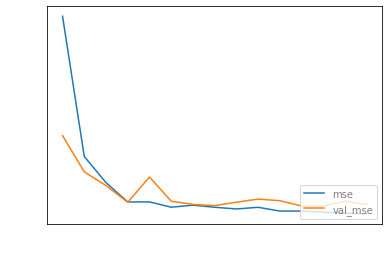

In [91]:
plt.plot(history.history['mse'], label='mse')
plt.plot(history.history['val_mse'], label = 'val_mse')
plt.xlabel('Epoch')
plt.ylabel('mse')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

[0.40178571]


(10.0, 55.0)

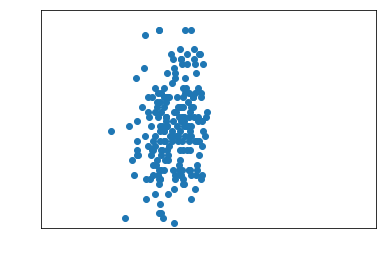

In [108]:
y_hat = model.predict(X_test);
error = y_test - y_hat;

thr = 5;
numCorrect = sum(abs(error) < thr);
numValidationImages = len(y_test);

accuracy = numCorrect/numValidationImages
print(accuracy)

squares = error**2;
rmse = np.sqrt(np.mean(squares))

plt.scatter(y_hat,y_test)
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

# plt.plot(np.linspace(10,55,10))

plt.xlim([10, 55])
plt.ylim([10, 55])

## Model 3. tuning parameters

## Model 4. grid search

In [ ]:
model = KerasClassifier(model=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#  -------------------------------------- FINAL MODEL EVALUATION ----------------------------------------------------

# -------------------------------------- CONCLUSION AND NEXT STEPS ----------------------------------------------

- with more time, I would look into creating my own architecture to mix categorical variables with image classification. this would help me take genre of a playlist into account, as my hypothesis is that album art could affect success of a track depending on the genre it's in. 